In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating project at `~/Documents/eth_courses/notebooks/dynamics/julia/demos/quad_2d`


In [2]:
# Pkg.add("Revise");

In [3]:
using Revise
using ModelingToolkit, LinearAlgebra
using GLMakie
using ControlSystems
using DifferentialEquations
using StaticArrays
# using Plots

include("utilities.jl")
include("types.jl")
include("linearize.jl")

linearize_system (generic function with 1 method)

## Utilities 

In [4]:
# 2D rotation matrix
R_2D(θ::Float64) = SA_F64[cos(θ) -sin(θ); sin(θ) cos(θ)];

In [5]:
motor_left = BLDCMotor(0, 12.5);
motor_right = BLDCMotor(0, 12.5);

quad_obj = Quad2d(1.0, 0.1, 0.003, motor_left, motor_right);
sim_params = SimParams(6,2,3, 0.01);
safety_box = SafetyBox(10, 10, 10, -10, -10, 0);

# Linearization

In [6]:
# equilibrium point
x₀ = Pose2D(2,1,0,0,0,0)

const thrust_equilibirum::Float64 = 9.81;
        
const f_1_equilibirum::Float64 = thrust_equilibirum/2
const f_2_equilibirum::Float64 = thrust_equilibirum/2

sys_c, sys_d, AB_symbolic = linearize_system(sim_params.Ts, x₀, quad_obj,[f_1_equilibirum, f_2_equilibirum]);

# LQR Controller

### Design controller

In [7]:
function get_dlqr_gain(;Q::Vector{Float64}, R::Vector{Float64})
    Q = Diagonal(Q) # Weighting matrix for state
    R = Diagonal(R) # Weighting matrix for input

    # Compute LQR gain matrix
    K = SMatrix{2,6}(lqr(sys_d,Q,R))

    return K
end 


K = get_dlqr_gain(;Q=[1.0,1.0,1.0,1.0,1.0,1.0], R=[1.0,1.0])

2×6 SMatrix{2, 6, Float64, 12} with indices SOneTo(2)×SOneTo(6):
 -0.544864  0.69938   3.16405  -0.805202  1.09019   0.625058
  0.544864  0.69938  -3.16405   0.805202  1.09019  -0.625058

## Discrete-time Linear Simulation

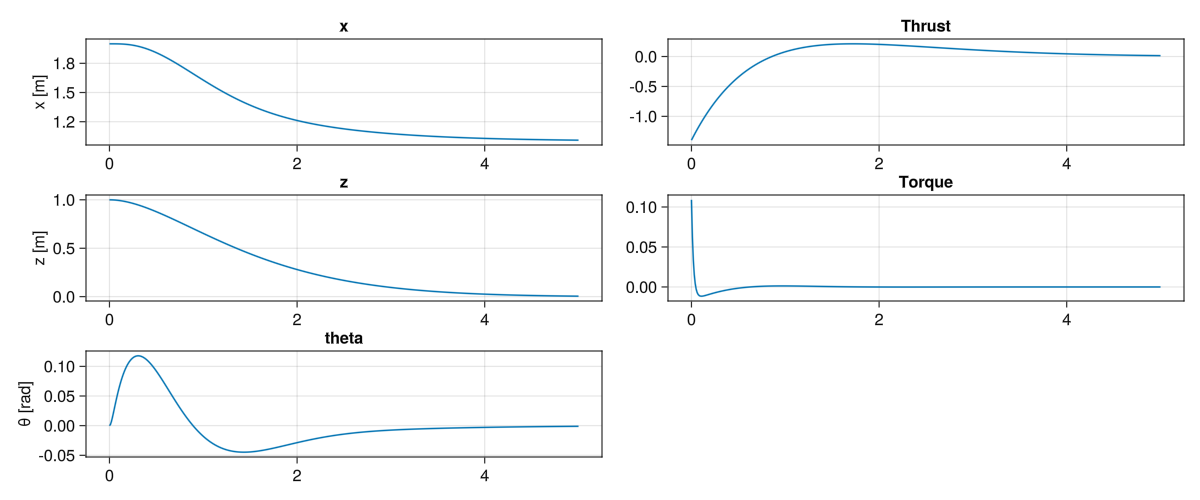

In [13]:
let
    
x_final = SA_F64[1,0,0,0,0,0]

# Simulation

u_l(x,t)  = -K * (x - x_final) 
t       = 0:sim_params.Ts:5              # Time vector
x0      = SA_F64[2,1,0,0,0,0]               # Initial condition

y_dl, t, x_dl, uout = lsim(sys_d,u_l,t,x0=x0)

quad_2d_plot_lsim(t,x_dl)

end

## Non-linear Simulation using DifferentialEquationsjl

In [14]:
function quad_2d_dynamics(X::Vector{Float64}, U::Vector{Float64}, params::NamedTuple)

    # extract the parameters
    m, g, l, I_xx = params
    
    g_vec = SA_F64[0;g] # use static array

    y = X[1]
    z = X[2]
    θ = X[3]
    ẏ = X[4]
    ż = X[5]
    θ̇ = X[6]
    
     # get the control input
    f_1 = U[1]
    f_2 = U[2]
    
    # compute thrust, torque
    f_thrust = f_1 + f_2 
    a_thrust = (f_thrust / m) # mass normalized thrust 
    
    τ = (f_1 - f_2) * l

    # translation E.O.M
    f = SA_F64[0; a_thrust]
    (ÿ, z̈) = R_2D(θ)*f + g_vec 

    # rotational E.O.M
    θ̈ = τ / I_xx

    return (ẏ, ż, θ̇, ÿ, z̈, θ̈ )
end

#Define the problem
function quad_2d(d_state, state, params, t)
    
    # extract the state
    X = state[1:sim_params.nx]

    # extract the control input
    U = state[sim_params.nx+1:end]

    (ẏ, ż, θ̇, ÿ, z̈, θ̈) = quad_2d_dynamics(X,U,params)
    
    d_state[1], d_state[2], d_state[3] = ẏ, ż, θ̇
    d_state[4], d_state[5], d_state[6] = ÿ, z̈, θ̈
end

quad_2d (generic function with 1 method)

In [15]:
# run at every timestep
condition(u,t,integrator) = true

function affect!(integrator)

     # Extract the state 
    X = integrator.u[1:sim_params.nx] 
    
    y::Float64 = X[1]
    z::Float64 = X[2]
    θ::Float64 = X[3]
    ẏ::Float64 = X[4]
    ż::Float64 = X[5]
    θ̇::Float64 = X[6]

    # # Limit operating space 
    # if z > params.safety_box.z_max
    #     z = clamp(z, params.safety_box.z_min, params.safety_box.z_max)
    #     ż = 0
    #     println("Z operational space constraint violated !")
    #     terminate!(integrator)

    # elseif z < params.safety_box.z_min
    #     z = clamp(z, params.safety_box.z_min, params.safety_box.z_max)
    #     ż = 0
    #     println("Landed !")
    #     terminate!(integrator)
    # end

    # if y < params.safety_box.y_min || y > params.safety_box.y_max
    #     y = clamp(y, params.safety_box.y_min, params.safety_box.y_max)
    #     ẏ = 0
    #     println("Y operational space constraint violated !")
    #     terminate!(integrator)
    # end

end

cb = DiscreteCallback(condition,affect!)

DiscreteCallback{typeof(condition), typeof(affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}(condition, affect!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, Bool[1, 1])

In [18]:
control_cb = PeriodicCallback(sim_params.Ts, initial_affect=true) do integrator
    nx = 6
    
    # Extract the parameters
    (; m, g, l, I_xx, safety_box, K, X_goal) = integrator.p

    # Extract the state 
    X = integrator.u[1:sim_params.nx] 

    # compute control input
    X_error = X - X_goal
    U = - K * X_error

    # println("X_req: $(X_req)")
    #println("X_error: $(X_error)")
    #println("State: $(X)")

    f_1 = f_1_equilibirum + U[1]
    f_2 = f_2_equilibirum + U[2]

    # constrain the control input
    f_1 = clamp(f_1, quad_obj.motor_left.thrust_min, quad_obj.motor_left.thrust_max)
    f_2 = clamp(f_2, quad_obj.motor_right.thrust_min, quad_obj.motor_right.thrust_max)

    #println("Control: $(U)")
    
    #Update the control-signal
    integrator.u[sim_params.nx+1:end] .= SA_F64[f_1, f_2]
end

#Initial Conditions
x₀ = Pose2D(0,1,0,0,0,0)

#Initial Conditions
X_final = [0,0,0,0,0,0]

# parameters
params = (; m=quad_obj.m, g=-9.81, l=quad_obj.L, I_xx = 0.003, safety_box = safety_box, K=K,  X_goal= X_final)

tspan = (0.0, 10.0);

initial_state = [x₀.y, x₀.z, x₀.θ, x₀.ẏ, x₀.ż, x₀.θ̇]; # state
u₀ = [0,0]; # control

initial_conditions = vcat(initial_state,u₀)

#Pass to solvers
cb_set = CallbackSet(control_cb,cb)
prob = ODEProblem(quad_2d, initial_conditions, tspan, params, callback=cb_set);
sol = solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep = false);

# quad_2d_plot_normal(sol)

## Benchmarking 

In [429]:
using BenchmarkTools

@btime solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep = false);

  6.541 ms (90135 allocations: 4.34 MiB)


In [20]:
@timev solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep = false);

  0.012421 seconds (92.08 k allocations: 4.278 MiB)
elapsed time (ns):  12420629
gc time (ns):       0
bytes allocated:    4486192
pool allocs:        92077
non-pool GC allocs: 6
minor collections:  0
full collections:   0


# Trajectory tracking 

### Create circle trajectory

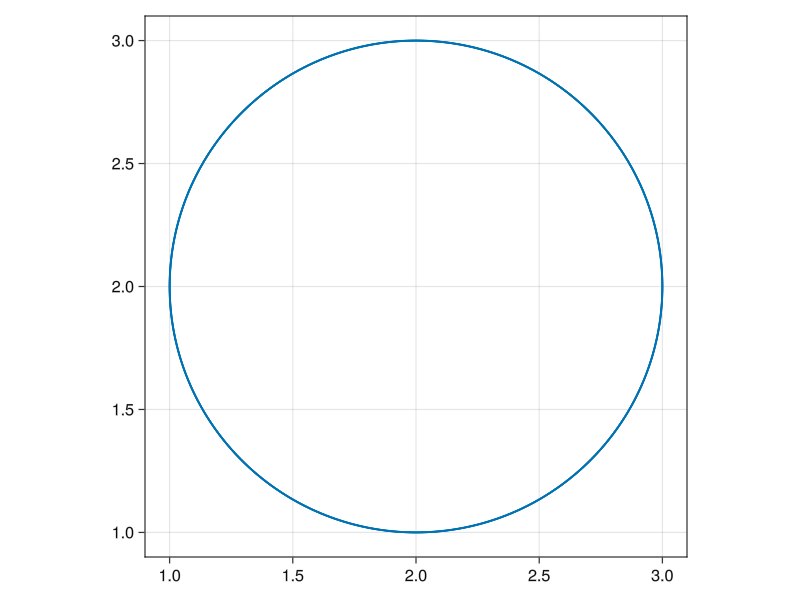

GLMakie.Screen(...)

In [21]:
include("trajectory_generation.jl")

circle_trajec_params = (r = 1, ω = 0.1*π, tspan = (0.0, 100.0), dt = sim_params.Ts, y₀=2, z₀=2)

x_vec, y_vec = generate_circle_trajectory(circle_trajec_params);

# @timev generate_trajectory(circle_trajec_params)
    
# plot trajectory
fig = Figure()
ax = Axis(fig[1, 1], aspect = 1)
lines!(ax, x_vec, y_vec)

display(fig)  

In [22]:
let 
include("trajectory_generation.jl")

t = 1.2 # seconds
(y_req, z_req, θ_req, ẏ_req, ż_req, θ̇_req) = generate_circle_trajectory(circle_trajec_params, 0.0)

X_req = generate_circle_trajectory(circle_trajec_params, sol.t);
# X_req

end 

6-element Vector{Any}:
  [3.0, 3.0, 2.9999950652018583, 2.9999950652018583, 2.9999950652018583, 2.9999950652018583, 2.999980260856137, 2.999980260856137, 2.999980260856137, 2.999980260856137  …  1.000019739143863, 1.000019739143863, 1.000019739143863, 1.000019739143863, 1.0000049347981417, 1.0000049347981417, 1.0000049347981417, 1.0000049347981417, 1.0, 1.0]
  [2.0, 2.0, 2.00314158748588, 2.00314158748588, 2.00314158748588, 2.00314158748588, 2.006283143965559, 2.006283143965559, 2.006283143965559, 2.006283143965559  …  2.0062831439655593, 2.0062831439655593, 2.0062831439655593, 2.0062831439655593, 2.0031415874858793, 2.0031415874858793, 2.0031415874858793, 2.0031415874858793, 2.0, 2.0]
  [0.03079232487879126, 0.03079232487879126, 0.030793266892892093, 0.030793266892892093, 0.030793266892892093, 0.030793266892892093, 0.030794107713312112, 0.030794107713312112, 0.030794107713312112, 0.030794107713312112  …  0.010267857780557502, 0.010267857780557502, 0.010267857780557502, 0.0102678577805

## Trajectory tracking demo

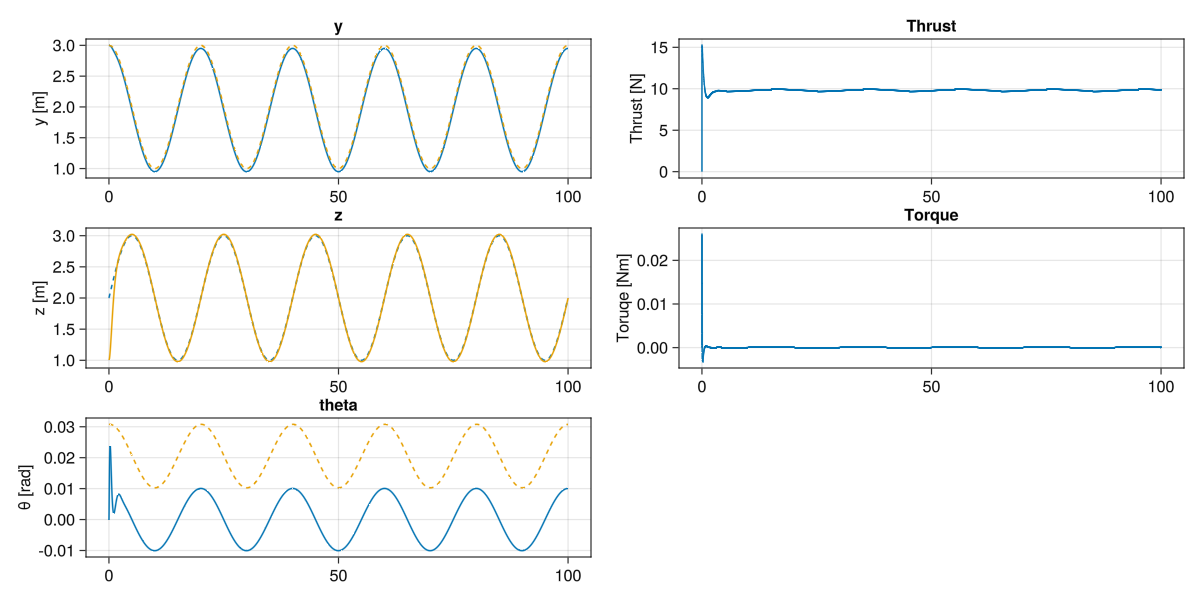

In [26]:
include("trajectory_generation.jl")
include("utilities.jl")

control_cb = PeriodicCallback(sim_params.Ts, initial_affect=true) do integrator
    nx = 6
    
    # Extract the parameters
    (; m, g, l, I_xx, safety_box, K, X_trajetory) = integrator.p

    # Extract the state 
    X = integrator.u[1:sim_params.nx] 

    X_req = X_trajetory(circle_trajec_params, integrator.t)
    
    # compute control input
    X_error = X - X_req
    U = - K * X_error

    # println("X_req: $(X_req)")
    #println("X_error: $(X_error)")
    #println("State: $(X)")

    f_1 = f_1_equilibirum + U[1]
    f_2 = f_2_equilibirum + U[2]

    # constrain the control input
    f_1 = clamp(f_1, quad_obj.motor_left.thrust_min, quad_obj.motor_left.thrust_max)
    f_2 = clamp(f_2, quad_obj.motor_right.thrust_min, quad_obj.motor_right.thrust_max)

    #println("Control: $(U)")
    
    #Update the control-signal
    integrator.u[sim_params.nx+1:end] .= SA_F64[f_1, f_2]
end

#Initial Conditions
x₀ = Pose2D(3,1,0,0,0,0)

# #Initial Conditions
# X_final = [0,0,0,0,0,0]

# compute LQR controller matrix K
K = get_dlqr_gain(;Q=[10.0,10.0,5.0,1.0,1.0,1.0], R=[1.0,1.0])

# parameters
params = (; m=quad_obj.m, g=-9.81, l=quad_obj.L, I_xx = 0.003, safety_box = safety_box, K=K, X_trajetory=generate_circle_trajectory)

tspan = (0.0, 100.0);

initial_state = [x₀.y, x₀.z, x₀.θ, x₀.ẏ, x₀.ż, x₀.θ̇]; # state
u₀ = [0,0]; # control

initial_conditions = vcat(initial_state,u₀)

#Pass to solvers
cb_set = CallbackSet(control_cb,cb)
prob = ODEProblem(quad_2d, initial_conditions, tspan, params, callback=cb_set);
sol = solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep = false);

# compute entire reference trajectory at sol.t timesteps
(y_req, z_req, θ_req, ẏ_req, ż_req, θ̇_req) = generate_circle_trajectory(circle_trajec_params, sol.t)

quad_2d_plot_normal(sol; y_ref=y_req, z_ref=z_req, theta_ref=θ_req) 

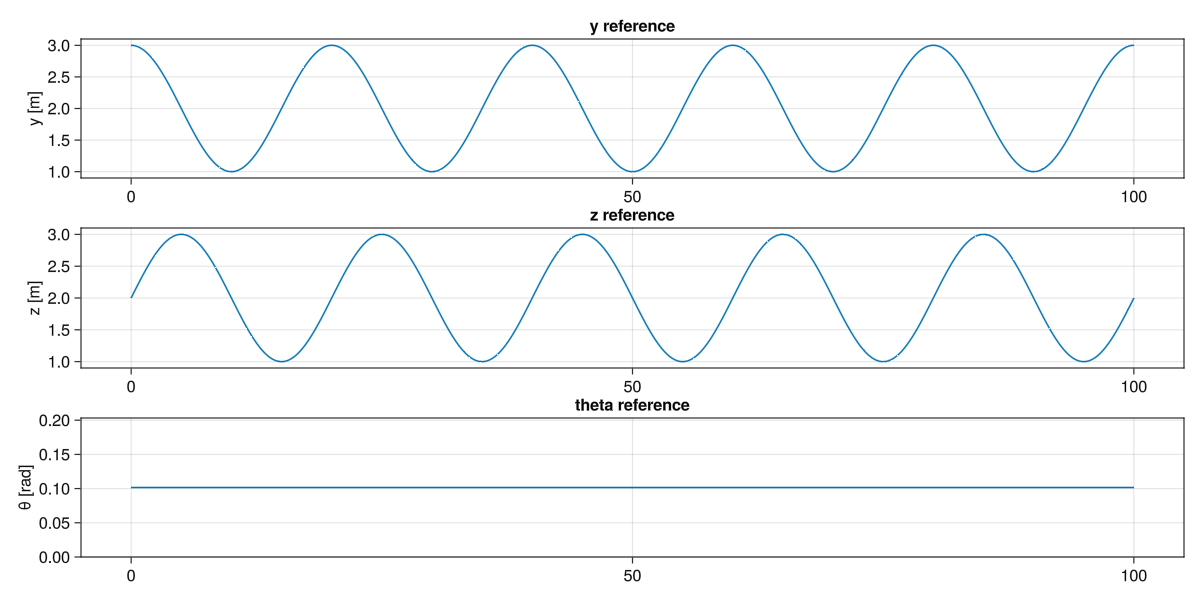

In [57]:
let 
include("trajectory_generation.jl")
include("utilities.jl")


t = 1.2 # seconds
(y_req, z_req, θ_req, ẏ_req, ż_req, θ̇_req) = generate_circle_trajectory(circle_trajec_params, sol.t)

# cos.(0.5)

# plot
quad_2d_plot_reference(sol; y_ref=y_req, z_ref=z_req, theta_ref=θ_req)

end



## Forward-diff demo

In [365]:
let

x(r, ω, t) = 1 * cos(1*t)
x(var) = x(var[1],var[2], var[3])

ẋ_fdiff =  ForwardDiff.gradient(x, [1, 1, 0.5])

# compare with analytical derivative
ẋ(r, ω, t) = -r * sin(ω*t) * ω

ẋ_analytical = ẋ(1, 1, 0.5)

# show results 
println("ẋ Analytical: $(ẋ_analytical)")
println("ẋ Forward-diff: $(ẋ_fdiff)")

end

ẋ Analytical: -0.479425538604203
ẋ Forward-diff: [-0.0, -0.0, -0.479425538604203]


In [394]:
let 
include("trajectory_generation.jl")

t = 1.2 # seconds
(x_req, y_req, θ_req, ẋ_req, ẏ_req, θ̇_req) = generate_circle_trajectory(circle_trajec_params, t)

end

6-element Vector{Float64}:
 2.309016994374948
 2.9510565162951536
 0.10158590543965393
 0.0
 0.0
 0.0

## Symbolics.jl function generation demo (theta_dot for 2d quadcopter differential flataness)

In [277]:
# let 
    
function get_θ̇()
    @variables t 
    D = Differential(t)
    
    @parameters ω m r
    
    @constants g=-9.81

    y = r*cos(ω*t)
    z = r*sin(ω*t)

    ẏ = D(y)
    ż = D(z)

    ÿ = D(ẏ)
    z̈ = D(ż)
    
    θ = expand_derivatives(atan(-m*ÿ, m*(z̈ -g)))
        
    θ̇ = expand_derivatives(D(θ))

     # build functions for θ and θ̇
    f_θ_expr = build_function(θ, [r,ω,m,g,t])
    f_θ̇_expr = build_function(θ̇, [r,ω,m,g,t])
        
    Base.remove_linenums!(f_θ_expr)
    Base.remove_linenums!(f_θ̇_expr)
        
     f_θ = eval(f_θ_expr)
     f_θ̇ = eval(f_θ̇_expr)

#     # # to build C function
#     # build_function(ÿ, [y,ω], target=Symbolics.CTarget())
    
     return f_θ, f_θ̇
end

let 

(f_θ, f_θ̇) = get_θ̇()

params = (; ω=0.2*π, m=1.0 ,g=-9.81, r=1.0)
    
θ::Float64= f_θ(SA[params.r, params.ω, params.m, params.g, 0.2])
θ̇::Float64 = f_θ̇(SA[params.r, params.ω, params.m, params.g, 0.2])

println("θ: ", θ);
println("θ̇: ", θ̇);
        
end

θ: 0.04010658647214026
θ̇: -0.002169918550128466


### Verification of f_θ (version 1)

In [278]:
let

params = (; ω=0.2*π, m=1.0 ,g=-9.81, r=1.0)

y(r,ω,t) = r*cos(ω*t)
z(r,ω,t) = r*sin(ω*t)
    
ÿ(r,ω,t) = -y(r,ω,t) * (ω^2)
z̈(r,ω,t) = -z(r,ω,t) * (ω^2)

# Analytical output 
t::Float64 = 0.2
θ_analytical::Float64 =  atan(-params.m * ÿ(params.r, params.ω, t) , params.m * (z̈(params.r, params.ω, t)  + 9.81))

# Output from symbolics.jl
(f_θ, f_θ̇) = get_θ̇()
θ_symbolics::Float64= f_θ(SA[params.r, params.ω, params.m, params.g, 0.2])

# show results 
println("θ_analytical: ", θ_analytical)
println("θ_symbolics: ", θ_symbolics)

end

θ_analytical: 0.04010658647214026
θ_symbolics: 0.04010658647214026


## Forwardfiff for (theta_dot for 2d quadcopter differential flataness)

In [283]:
let

using ForwardDiff

y(r,ω,t) = (r*cos(ω*t)) 
z(r,ω,t) = (r*sin(ω*t)) 
    
ÿ(r,ω,t) = -y(r,ω,t) * (ω^2)
z̈(r,ω,t) = -z(r,ω,t) * (ω^2)
    
θ(ω,m,g,r,t) = atan(-m*ÿ(r,ω,t), m*(z̈(r,ω,t) -g))

θ(var) = θ( var[1],var[2],var[3],var[4],var[5])

params = (; ω=0.2*π, m=1.0 ,g=-9.81, r=1.0)

# result from forwarddiff.jl
θ̇_fdiff =  ForwardDiff.gradient(θ, [params.ω, params.m, params.g, params.r, 0.2])

# result from symbolics.jl
(f_θ, f_θ̇) = get_θ̇()
θ_symbolics::Float64=  f_θ̇(SA[params.r, params.ω, params.m, params.g, 0.2])

# show results 
println("θ_forwarddiff: ", θ̇_fdiff[end])
println("θ_symbolics: ", θ_symbolics)
    
end

θ_forwarddiff: -0.002169918550128466
θ_symbolics: -0.002169918550128466
